In [171]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torchvision.transforms as transforms
from PIL import Image
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import scale_cam_image, show_cam_on_image

from ssl_wafermap.models.knn import *
from ssl_wafermap.utilities.transforms import get_inference_transforms

In [ ]:
df = pd.read_pickle("../data/processed/WM811K/train_data.pkl.xz")
# Select a random wafer with the "Scratch" failureType
random_img = df.loc[df.failureType == "Scratch"].waferMap.sample().values[0]

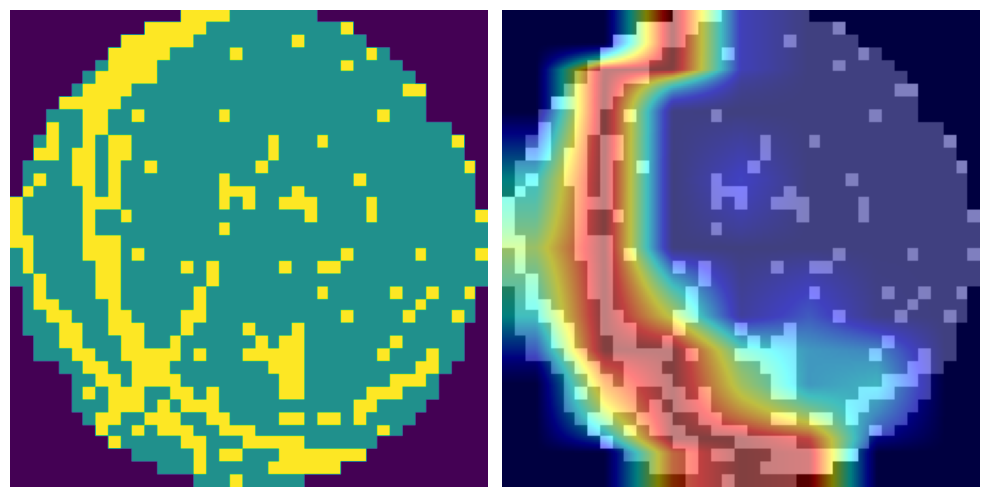

In [172]:
# Load the model
model = FastSiam.load_from_checkpoint("../models/new_knn/FastSiam/checkpoints/epoch=149-step=87450.ckpt")
model.eval()
model.cpu()

# Initialize GradCAM
backbone = model.backbone
target_layer = backbone.layer4[-1]
cam = EigenCAM(backbone, [target_layer], use_cuda=False)

# Get the CAM image
transforms = get_inference_transforms(normalize=False)
img = transforms(random_img)
tensor = transforms(random_img).unsqueeze(0)
cam_img = cam(input_tensor=tensor)[0, :, :]
renormalized_cam = scale_cam_image(cam_img)

# Get the CAM overlaid on the original image
show_cam = show_cam_on_image(img.numpy().transpose((1, 2, 0)), renormalized_cam, use_rgb=True)

# Plot the original image and the CAM image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(tensor.squeeze(0)[0])
ax[1].imshow(show_cam, cmap="magma")
for a in ax:
    a.axis("off")

os.makedirs("../reports/figures/gradcam", exist_ok=True)

plt.tight_layout()
plt.savefig("../reports/figures/gradcam/scratch.png", bbox_inches="tight")
plt.show()

In [173]:
# Wrap the above code in a function
def get_cam_image(img, model, cam, transforms, name):
    img = transforms(img)
    tensor = transforms(img).unsqueeze(0)
    cam_img = cam(input_tensor=tensor)[0, :, :]
    renormalized_cam = scale_cam_image(cam_img)
    show_cam = show_cam_on_image(img.numpy().transpose((1, 2, 0)), renormalized_cam, use_rgb=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(tensor.squeeze(0)[0])
    ax[1].imshow(show_cam, cmap="magma")
    for a in ax:
        a.axis("off")

    if name:
        plt.tight_layout()
        plt.savefig(f"../reports/figures/gradcam/{name}.png", bbox_inches="tight")
    plt.show()
    

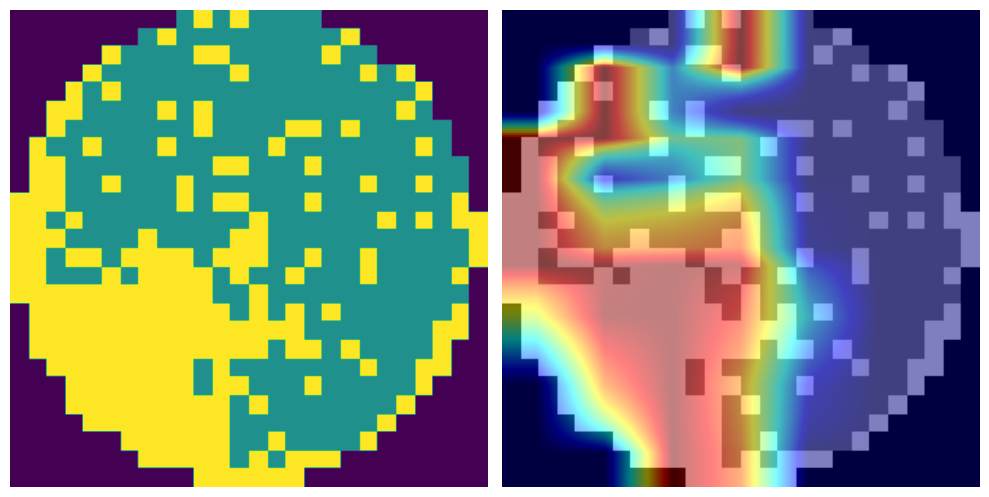

In [212]:
rando = df.loc[df.failureType == "Edge-Loc"].waferMap.sample().values[0]
get_cam_image(rando, model, cam, transforms, name="edge-loc")